
# Float vertical position control, ensta prototype


---

## Equations of motion

For basics about float dynamics go [here](https://github.com/apatlpo/cognac/blob/master/instrum/float_dynamics_basics.ipynb)

We assume now that the float has the ability to control its volume between two bounds $V+v_{min}$ and $V+v_{max}$
with a precision $dv$.

---

## Control

We control the float vertical position with sliding modes, see [this notebook](https://github.com/apatlpo/cognac/blob/master/instrum/zcontrol_realistic.ipynb) for more details about control.


In [1]:
%matplotlib inline
#%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import numpy as np
from scipy.interpolate import interp1d
import time
from copy import deepcopy

from matplotlib import animation, rc
from IPython.display import HTML

from float_lib import *

WOA water profile at lon=-50, lat=40


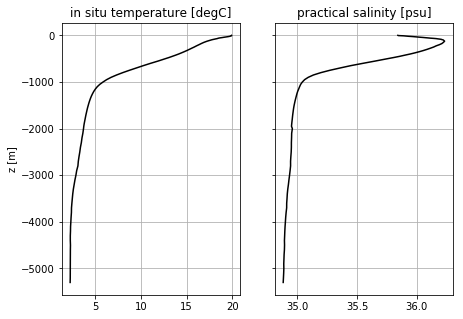

In [2]:
# select a water profile
w = waterp(lon=-50.,lat=40.)
print(w)
#w.show_on_map()

--- 
## Instantiate the float object

In [3]:
# Init now active control of the vertical position

#
z=np.arange(-100.,0.,1.)
rho_w, p, temp = w.get_rho(z), w.get_p(z), w.get_temp(z)

#
f = autonomous_float(model='ENSTA')

# adjust mass to be at equilibrium at -25m
iz = np.argmin(np.abs(z+25))
f.adjust_m(p[iz],temp[iz],rho_w[iz])

# set vmax such that the float has an extra buoyancy at the surface equal
# to a cylinder ot 2cm radius and height of 10cm (antenna casing)
iz = np.argmin(np.abs(z+0.))
vmax = f.volume4equilibrium(p[iz],temp[iz],rho_w[iz]) + .1*np.pi*.02**2
# use d_max to prescribe piston max course
dmax = .07

#
f.init_piston(d_max=dmax,vol_max=vmax,vol=vmax)
print(f)

# compute bounds on motions
fmax, fmin, afmax, wmax = f.compute_bounds(w,-500.)

-3258.3 g were added to the float in order to be at equilibrium at 25 dbar 

Piston max displacement set from max volume
Float parameters: 
  L     = 0.50 m      - float length
  r     = 0.06 m      - float radius
  m     = 5.79 kg     - float mass
  V     = 5.65e+03 cm^3   - float volume
  rho_cte     = 1.02e+09 kg.cm^3   - float constant density
  gamma = 9.30e-05 /dbar  - mechanical compressibility
  alpha = 0.00e+00 /degC  - thermal compressibility
  temp0 = 0.00e+00  degC  - reference temperature
  a = 1.00e+00  (no dimension)  - float added mass
  c0 = 0.00e+00  (no dimension)  - float drag parameter 0
  c1 = 1.00e+00  (no dimension)  - float drag parameter 1
Piston parameters and state: 
  r     = 25.00 mm        - piston radius
  phi   = 0.00 rad       - present angle of rotation
  d     = 0.00 mm        - present piston displacement
  vol   = 114.46 cm^3      - present volume addition
  lead  = 0.18 cm        - screw lead
  d_increment  = 0.00 m        - smallest variation of 

In [4]:
rho_eq = rho_w[iz]
temp_eq = temp[iz]
p_eq=20
f.piston_update_vol(f.piston.vol_max)
print(rho_eq - f.rho(p=p_eq, temp=temp_eq))
f.piston_update_vol(f.piston.vol_min)
print(rho_eq - f.rho(p=p_eq, temp=temp_eq))

20.597707653301427
-3.9710755106480065


In [5]:
# adjust piston to be at equilibrium 20m
iz = np.argmin(np.abs(z+20.))
vstart = f.set_piston4equilibrium(p[iz],temp[iz],rho_w[iz])
print('z equilibrium = %.1fm' %(f.z4equilibrium(w) ) ) # check

# compute float vertical displacement associated with 1mm piston displacement
#f.piston.update_d(f.piston.d+.001)
#f.piston_update_vol()
#print('z equilibrium after 1 mm piston displacement = %.1fm' %(f.z4equilibrium(w) ) )

Piston reset : vol=-2.2e+00 cm^3  
z equilibrium = -20.0m


In [6]:
rho_w[iz]

1025.6392627547211

In [7]:
f.rho(p=p[iz],temp=temp[iz])

1025.6392627548016

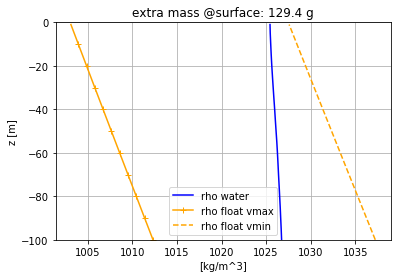

In [8]:
# show densities
plot_float_density(z, f, w)

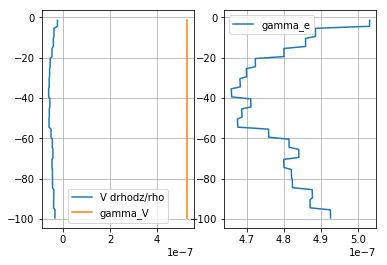

In [9]:
gamma_V = f.V*f.gamma
gamma_rho = f.V*np.diff(rho_w)/f.rho_cte/np.diff(z)
zm = (z[1:]+z[:-1])*.5

plt.figure()
ax=plt.subplot(121)
ax.plot(gamma_rho, zm, label='V drhodz/rho')
ax.plot(gamma_V+0.*zm, zm, label='gamma_V')
ax.grid()
ax.legend()

ax=plt.subplot(122)
ax.plot(gamma_rho+gamma_V, zm, label='gamma_e')
ax.grid()
ax.legend()

---

## From the surface down to a target level

In [10]:
# we start by constructing a trajectory that can be followed by the float
z_target = descent(3600, -25., f, w)

Acceleration and velocity bounds (zmin=-500m,zmax=0m):
fmax/m=2.2e-01 m^2/s, fmin/m= -4.5e-01 m^2/s, wmax= 386.3 cm/s
For accelerations, equivalent speed reached in 1min:
  fmax 1.3e+03 cm/s, fmin/m= -2.7e+03 cm/s


In [33]:
def plot_kalman(f):
    fig = plt.figure(figsize=(15,10))
    #
    ax=fig.add_subplot(231)
    ax.plot(f.log.t,f.log.z,'-', label = "real depth")
    ax.plot(f.t_kalman[1:],-f.log.z_kalman, label ="estimated depth")
    ax.set_title("depth as a function of time")
    ax.set_xlabel("t (s)")
    ax.set_ylabel("z (m)")
    ax.grid()
    legend = ax.legend(loc='best', shadow=True, fontsize='medium')
    #
    ax=fig.add_subplot(232)
    ax.plot(f.log.t,f.log.w, label = "real velocity")
    ax.plot(f.t_kalman[1:],-f.log.w_kalman, label ="estimated velocity")
    ax.set_title("velocity as a function of time")
    ax.set_xlabel("t (s)")
    ax.set_ylabel("w (m/s)")
    ax.grid()
    legend = ax.legend(loc='best', shadow=True, fontsize='medium')
    #
    ax=fig.add_subplot(233)
    ax.plot(f.log.t,f.log.gammaV, label = "real equivalent compressibility")
    ax.plot(f.t_kalman[1:],f.log.gammaE_kalman, label ="estimated equivalent compressibility")
    ax.set_title("equivalent compressibility as a function of time")
    ax.set_xlabel("t (s)")
    ax.set_ylabel("gammaE (m^2)")
    ax.grid()
    legend = ax.legend(loc='best', shadow=True, fontsize='medium')
    #
    ax=fig.add_subplot(234)
    ax.plot(f.log.t,f.log.Ve, label = "real Ve volume")
    ax.plot(f.t_kalman[1:],f.log.Ve_kalman, label ="estimated Ve volume")
    ax.set_title("volume Ve as a function of time")
    ax.set_xlabel("t (s)")
    ax.set_ylabel("Ve (m^3)")
    ax.grid()
    legend = ax.legend(loc='best', shadow=True, fontsize='medium')   
    #
    ax=fig.add_subplot(235)
    ax.plot(f.log.t,-f.log.dwdt, label = "real acceleration")
    ax.plot(f.t_kalman[1:],f.log.dwdt_kalman, label ="estimated acceleration")
    ax.set_title("acceleration dw/dt as a function of time")
    ax.set_xlabel("t (s)")
    ax.set_ylabel("dw/dt (m.s^-2)")
    ax.grid()
    legend = ax.legend(loc='best', shadow=True, fontsize='medium') 
    
    
    
    def plot_regulation(f, vmax, nu, tau, delta):
        fig = plt.figure(figsize=(10,5))
        #
        ax=fig.add_subplot(121)
        ax.plot(f.log.t,f.log.z,'-', label = "depth")
        ax.set_title("depth as a function of time\n vmax:%.2f m/s, nu:%.4f m/s, tau:%.2f s, delta:%.2f m"%(vmax,nu,tau,delta))
        ax.set_xlabel("t (s)")
        ax.set_ylabel("z (m)")
        ax.grid()
        #
        ax=fig.add_subplot(122)
        ax.plot(f.log.t,f.log.w, label = "velocity")
        ax.set_title("velocity as a function of time\n vmax:%.2f m/s, nu:%.4f m/s, tau:%.2f s, delta:%.2f m"%(vmax,nu,tau,delta))
        ax.set_xlabel("t (s)")
        ax.set_ylabel("w (m/s)")
        ax.grid()
        # 
    
    
def plot_depth(ax,f, vmax, nu, tau, delta):

    ax.plot(f.log.t,f.log.z, label = "vmax:%.2f m/s, nu:%.4f m/s, tau:%.2f s, delta:%.2f m"%(vmax,nu,tau,delta))
    ax.set_title("depth as a function of time")
    ax.set_xlabel("t (s)")
    ax.set_ylabel("z (m)")
    ax.grid()
    legend = ax.legend(loc='best', shadow=True, fontsize='medium') 
    #

def plot_velocity(ax,f, vmax, nu, tau, delta):

    ax.plot(f.log.t,f.log.w, label = "vmax:%.2f m/s, nu:%.4f m/s, tau:%.2f s, delta:%.2f m"%(vmax,nu,tau,delta))
    ax.set_title("velocity as a function of time")
    ax.set_xlabel("t (s)")
    ax.set_ylabel("w (m/s)")
    ax.grid()
    legend = ax.legend(loc='best', shadow=True, fontsize='medium') 
    # 

---

## Parameter estimation functions for feedback regulation

In [34]:
#Functions and parameters necesary to estimate parameters for feedback regulation

'''
parameters:
    g : gravity acceleration [m.s^-2]
    m : float mass [kg]
    a : float added mass [no dimension]
    r : float radius [m]
    L : float length [m]
    rho_w : water density [kg.m^3]
    omega :  current rotation rate [rad/s]
    lead : screw lead (i.e. displacement after one screw revolution) [m]
    r_piston : piston radius [m]
    u : piston flow [m^3.s^-1]
'''

params_ensta = {'r': 0.06, 'L': 0.5, 'a': 1., 'omega' : 20/48*2.*np.pi, 'lead' : 0.00175, 'r_piston' : 0.025}
params_ensta['m'] = 9.0 #1000. * np.pi * params_ensta['r'] ** 2 * params_ensta['L']

params_ensta['u'] = omega2dvdt(params_ensta['omega'], params_ensta['lead'], params_ensta['r_piston'])



params_ifremer = {'r': 0.07, 'L': 0.8278, 'a': 1., 'omega' : 20/48*2.*np.pi, 'lead' : 1.0, 'r_piston' : 0.0195/2}
params_ifremer['m'] = 13.315 #1000. * np.pi * params_ifremer['r'] ** 2 * params_ifremer['L']

params_ifremer['u'] = omega2dvdt(params_ifremer['omega'], params_ifremer['lead'], params_ifremer['r_piston'])

---

## Feedback regulation without Kalman filter
### Regulation parameters : nu variable, tau and delta fixed

 ctrl: dt_ctrl = 0.1
 ctrl: dz_nochattering = 0.0
 ctrl: tau = 2.0
 ctrl: nu = 0.006366197723675814
 ctrl: delta = 1.0
 ctrl: gamma = 9.3e-05
 ctrl: L = 0.5
 ctrl: c1 = 1.0
 ctrl: m = 5.78669211288864
 ctrl: gammaV = 5.259026102109313e-07
 ctrl: rho = 1599.5071780735482
 ctrl: a = 1.0
 ctrl: mode = feedback
Start time stepping for 33 min ...
... time stepping done
 ctrl: dt_ctrl = 0.1
 ctrl: dz_nochattering = 0.0
 ctrl: tau = 2.0
 ctrl: nu = 0.0445633840657307
 ctrl: delta = 1.0
 ctrl: gamma = 9.3e-05
 ctrl: L = 0.5
 ctrl: c1 = 1.0
 ctrl: m = 5.78669211288864
 ctrl: gammaV = 5.259026102109313e-07
 ctrl: rho = 1599.5071780735482
 ctrl: a = 1.0
 ctrl: mode = feedback
Start time stepping for 33 min ...
... time stepping done
 ctrl: dt_ctrl = 0.1
 ctrl: dz_nochattering = 0.0
 ctrl: tau = 2.0
 ctrl: nu = 0.12732395447351627
 ctrl: delta = 1.0
 ctrl: gamma = 9.3e-05
 ctrl: L = 0.5
 ctrl: c1 = 1.0
 ctrl: m = 5.78669211288864
 ctrl: gammaV = 5.259026102109313e-07
 ctrl: rho = 1599.507178073548

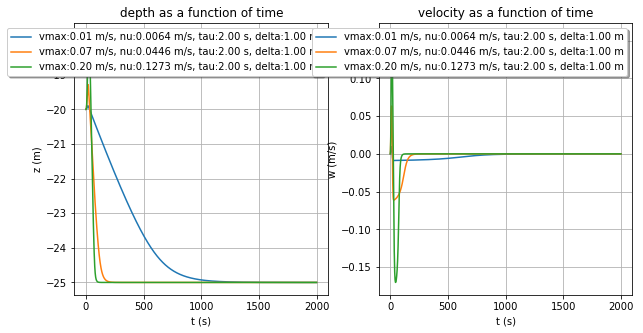

In [35]:
# time step float with control
#control = {'tau': 10.,'dz_nochattering': 1., 'mode': 'sliding', 'd3y_ctrl': afmax/f.m/1.}
#control = {'tau': 2.0, 'dz_nochattering': 1., 'mode': 'feedback', 'nu': 0.03*2./np.pi, 'delta': 0.02}
#control = {'tau': 2.0, 'dz_nochattering': 1., 'mode': 'kalman_feedback', 'nu': 0.03*2./np.pi, 'delta': 1.}



tab_vmax = [0.01,0.07,0.20] #Let's admit that the float will not reach a vertical velocity upper than 0.10 m/s.
tab_nu = [(2/np.pi)*vmax_reached for vmax_reached in tab_vmax]
tab_tau = [2.0 for i in range(len(tab_vmax))] #tv(vmax_reached, params_ensta)
tab_delta = [1.0 for i in range(len(tab_vmax))] #zv(vmax_reached, params_ensta)

control = {'tau': tab_tau[0], 'dz_nochattering': 0., 'mode': 'feedback', 'nu': tab_nu[0], 'delta': tab_delta[0]}

fig = plt.figure(figsize=(10,5))
#
ax1=fig.add_subplot(121)
ax2=fig.add_subplot(122)

for i in range(len(tab_vmax)):
    control.update({'nu':tab_nu[i]})
    #
    #
    dt = 1. #s
    depth_rms = 1e-5 # m
    vel_rms = depth_rms/dt # mm/s
    Ve_rms = 1e-5
    t2V = f.piston.vol_error  #vol_error = 7.e-08
    gamma_alpha_gammaE = 1e-8
    A_coeff = g*f.rho_cte/((f.a+1)*f.m)
    kalman = {'dt': dt, 'vol_error': t2V,
              'gammaV' : f.gammaV,
              'gamma': np.diag([vel_rms**2, depth_rms**2, gamma_alpha_gammaE**2, (10.*t2V)**2]),
              'gamma_alpha': np.diag([(dt*A_coeff*Ve_rms)**2, (depth_rms*10.)**2, gamma_alpha_gammaE**2, (1e-1*dt*Ve_rms)**2] ),
              'gamma_beta': np.diag([depth_rms**2])}
    #
    f.time_step(w,T=2000., dt_step=.1, dt_store=1., z=-20., w=0., v=vstart,
                 usepiston=True, z_target=z_target, ctrl=control, kalman=kalman, verbose=0)

    plot_depth(ax1, f, tab_vmax[i], tab_nu[i], tab_tau[i], tab_delta[i])
    plot_velocity(ax2, f, tab_vmax[i], tab_nu[i], tab_tau[i], tab_delta[i])

---

### Regulation parameters : tau variable, nu and delta fixed

 ctrl: dt_ctrl = 0.1
 ctrl: dz_nochattering = 0.0
 ctrl: tau = 0.01
 ctrl: nu = 0.01909859317102744
 ctrl: delta = 1.0
 ctrl: gamma = 9.3e-05
 ctrl: L = 0.5
 ctrl: c1 = 1.0
 ctrl: m = 5.78669211288864
 ctrl: gammaV = 5.259026102109313e-07
 ctrl: rho = 1599.5071780735482
 ctrl: a = 1.0
 ctrl: mode = feedback
Start time stepping for 33 min ...
... time stepping done
 ctrl: dt_ctrl = 0.1
 ctrl: dz_nochattering = 0.0
 ctrl: tau = 1.0
 ctrl: nu = 0.01909859317102744
 ctrl: delta = 1.0
 ctrl: gamma = 9.3e-05
 ctrl: L = 0.5
 ctrl: c1 = 1.0
 ctrl: m = 5.78669211288864
 ctrl: gammaV = 5.259026102109313e-07
 ctrl: rho = 1599.5071780735482
 ctrl: a = 1.0
 ctrl: mode = feedback
Start time stepping for 33 min ...
... time stepping done
 ctrl: dt_ctrl = 0.1
 ctrl: dz_nochattering = 0.0
 ctrl: tau = 100.0
 ctrl: nu = 0.01909859317102744
 ctrl: delta = 1.0
 ctrl: gamma = 9.3e-05
 ctrl: L = 0.5
 ctrl: c1 = 1.0
 ctrl: m = 5.78669211288864
 ctrl: gammaV = 5.259026102109313e-07
 ctrl: rho = 1599.507178073

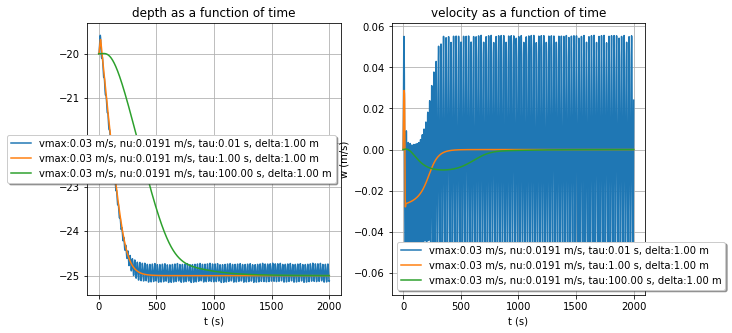

In [36]:
tab_tau = [0.01, 1.0, 100.0] #tv(vmax_reached, params_ensta)
tab_vmax = [0.03 for i in range(len(tab_tau))] #Let's admit that the float will not reach a vertical velocity upper than 0.10 m/s.
tab_nu = [(2/np.pi)*vmax_reached for vmax_reached in tab_vmax]
tab_delta = [1.0 for i in range(len(tab_vmax))] #zv(vmax_reached, params_ensta)

control = {'tau': tab_tau[0], 'dz_nochattering': 0., 'mode': 'feedback', 'nu': tab_nu[0], 'delta': tab_delta[0]}

fig = plt.figure(figsize=(10,5))
#
ax1=fig.add_subplot(121)
ax2=fig.add_subplot(122)

for i in range(len(tab_vmax)):
    control.update({'tau':tab_tau[i]})
    #
    #
    dt = 1. #s
    depth_rms = 1e-5 # m
    vel_rms = depth_rms/dt # mm/s
    Ve_rms = 1e-5
    t2V = f.piston.vol_error  #vol_error = 7.e-08
    gamma_alpha_gammaE = 1e-8
    A_coeff = g*f.rho_cte/((f.a+1)*f.m)
    kalman = {'dt': dt, 'vol_error': t2V,
              'gammaV' : f.gammaV,
              'gamma': np.diag([vel_rms**2, depth_rms**2, gamma_alpha_gammaE**2, (10.*t2V)**2]),
              'gamma_alpha': np.diag([(dt*A_coeff*Ve_rms)**2, (depth_rms*10.)**2, gamma_alpha_gammaE**2, (1e-1*dt*Ve_rms)**2] ),
              'gamma_beta': np.diag([depth_rms**2])}
    #
    f.time_step(w,T=2000., dt_step=.1, dt_store=1., z=-20., w=0., v=vstart,
                 usepiston=True, z_target=z_target, ctrl=control, kalman=kalman, verbose=0)

    plot_depth(ax1, f, tab_vmax[i], tab_nu[i], tab_tau[i], tab_delta[i])
    plot_velocity(ax2, f, tab_vmax[i], tab_nu[i], tab_tau[i], tab_delta[i])

---

### Regulation parameters : delta variable, nu and tau fixed

 ctrl: dt_ctrl = 0.1
 ctrl: dz_nochattering = 0.0
 ctrl: tau = 2.0
 ctrl: nu = 0.01909859317102744
 ctrl: delta = 0.001
 ctrl: gamma = 9.3e-05
 ctrl: L = 0.5
 ctrl: c1 = 1.0
 ctrl: m = 5.78669211288864
 ctrl: gammaV = 5.259026102109313e-07
 ctrl: rho = 1599.5071780735482
 ctrl: a = 1.0
 ctrl: mode = feedback
Start time stepping for 33 min ...
... time stepping done
 ctrl: dt_ctrl = 0.1
 ctrl: dz_nochattering = 0.0
 ctrl: tau = 2.0
 ctrl: nu = 0.01909859317102744
 ctrl: delta = 0.2
 ctrl: gamma = 9.3e-05
 ctrl: L = 0.5
 ctrl: c1 = 1.0
 ctrl: m = 5.78669211288864
 ctrl: gammaV = 5.259026102109313e-07
 ctrl: rho = 1599.5071780735482
 ctrl: a = 1.0
 ctrl: mode = feedback
Start time stepping for 33 min ...
... time stepping done
 ctrl: dt_ctrl = 0.1
 ctrl: dz_nochattering = 0.0
 ctrl: tau = 2.0
 ctrl: nu = 0.01909859317102744
 ctrl: delta = 1.0
 ctrl: gamma = 9.3e-05
 ctrl: L = 0.5
 ctrl: c1 = 1.0
 ctrl: m = 5.78669211288864
 ctrl: gammaV = 5.259026102109313e-07
 ctrl: rho = 1599.5071780735

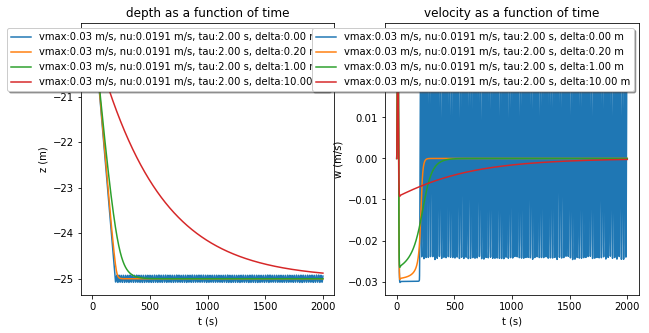

In [37]:
tab_delta = [0.001, 0.2, 1.0 , 10.0] #zv(vmax_reached, params_ensta)
tab_tau = [2.0 for i in range(len(tab_delta))] #tv(vmax_reached, params_ensta)
tab_vmax = [0.03 for i in range(len(tab_tau))] #Let's admit that the float will not reach a vertical velocity upper than 0.10 m/s.
tab_nu = [(2/np.pi)*vmax_reached for vmax_reached in tab_vmax]

control = {'tau': tab_tau[0], 'dz_nochattering': 0., 'mode': 'feedback', 'nu': tab_nu[0], 'delta': tab_delta[0]}

fig = plt.figure(figsize=(10,5))
#
ax1=fig.add_subplot(121)
ax2=fig.add_subplot(122)

for i in range(len(tab_vmax)):
    control.update({'delta':tab_delta[i]})
    #
    #
    dt = 1. #s
    depth_rms = 1e-5 # m
    vel_rms = depth_rms/dt # mm/s
    Ve_rms = 1e-5
    t2V = f.piston.vol_error  #vol_error = 7.e-08
    gamma_alpha_gammaE = 1e-8
    A_coeff = g*f.rho_cte/((f.a+1)*f.m)
    kalman = {'dt': dt, 'vol_error': t2V,
              'gammaV' : f.gammaV,
              'gamma': np.diag([vel_rms**2, depth_rms**2, gamma_alpha_gammaE**2, (10.*t2V)**2]),
              'gamma_alpha': np.diag([(dt*A_coeff*Ve_rms)**2, (depth_rms*10.)**2, gamma_alpha_gammaE**2, (1e-1*dt*Ve_rms)**2] ),
              'gamma_beta': np.diag([depth_rms**2])}
    #
    f.time_step(w,T=2000., dt_step=.1, dt_store=1., z=-20., w=0., v=vstart,
                 usepiston=True, z_target=z_target, ctrl=control, kalman=kalman, verbose=0)

    plot_depth(ax1, f, tab_vmax[i], tab_nu[i], tab_tau[i], tab_delta[i])
    plot_velocity(ax2, f, tab_vmax[i], tab_nu[i], tab_tau[i], tab_delta[i])


---

### Regulation parameters : best case for vmax = 0.10 m/s

 ctrl: dt_ctrl = 0.1
 ctrl: dz_nochattering = 0.0
 ctrl: tau = 16.03396085672878
 ctrl: nu = 0.06366197723675814
 ctrl: delta = 0.5344653618909595
 ctrl: gamma = 9.3e-05
 ctrl: L = 0.5
 ctrl: c1 = 1.0
 ctrl: m = 5.78669211288864
 ctrl: gammaV = 5.259026102109313e-07
 ctrl: rho = 1599.5071780735482
 ctrl: a = 1.0
 ctrl: mode = feedback
Start time stepping for 33 min ...
... time stepping done


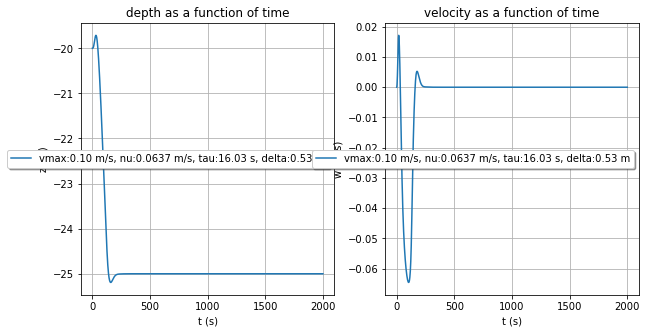

In [38]:
vmax_reached = 0.10 #Let's admit that the float will not reach a vertical velocity upper than 0.10 m/s.
delta = zv(vmax_reached, params_ensta)
tau = tv(vmax_reached, params_ensta)
nu = (2/np.pi)*vmax_reached

control = {'tau': tau, 'dz_nochattering': 0., 'mode': 'feedback', 'nu': nu, 'delta': delta}

fig = plt.figure(figsize=(10,5))
#
ax1=fig.add_subplot(121)
ax2=fig.add_subplot(122)


dt = 1. #s
depth_rms = 1e-5 # m
vel_rms = depth_rms/dt # mm/s
Ve_rms = 1e-5
t2V = f.piston.vol_error  #vol_error = 7.e-08
gamma_alpha_gammaE = 1e-8
A_coeff = g*f.rho_cte/((f.a+1)*f.m)
kalman = {'dt': dt, 'vol_error': t2V,
          'gammaV' : f.gammaV,
          'gamma': np.diag([vel_rms**2, depth_rms**2, gamma_alpha_gammaE**2, (10.*t2V)**2]),
          'gamma_alpha': np.diag([(dt*A_coeff*Ve_rms)**2, (depth_rms*10.)**2, gamma_alpha_gammaE**2, (1e-1*dt*Ve_rms)**2] ),
          'gamma_beta': np.diag([depth_rms**2])}
#
f.time_step(w,T=2000., dt_step=.1, dt_store=1., z=-20., w=0., v=vstart,
             usepiston=True, z_target=z_target, ctrl=control, kalman=kalman, verbose=0)

plot_depth(ax1, f, vmax_reached, nu, tau, delta)
plot_velocity(ax2, f, vmax_reached, nu, tau, delta)

---

## Feedback regulation with Kalman filter
### Kalman filter parameters : Ve_rms variable

 ctrl: dt_ctrl = 0.1
 ctrl: dz_nochattering = 0.0
 ctrl: tau = 8.78216204738521
 ctrl: nu = 0.01909859317102744
 ctrl: delta = 0.08782162047385213
 ctrl: kalman = <float_lib.Kalman object at 0x7fe8ab14fba8>
 ctrl: mode = kalman_feedback
Start time stepping for 25 min ...
... time stepping done


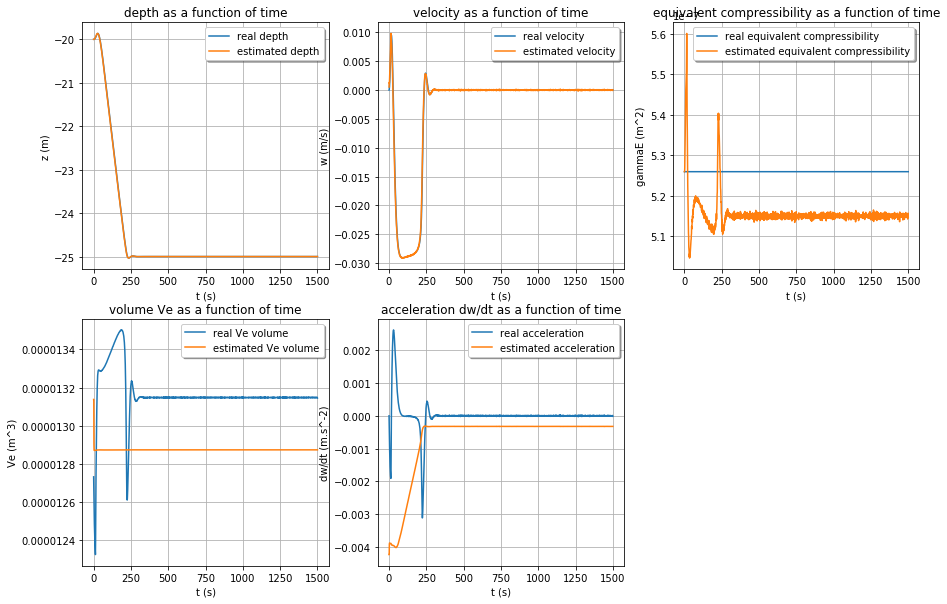

In [16]:
# time step float with control
#control = {'tau': 10.,'dz_nochattering': 1., 'mode': 'sliding', 'd3y_ctrl': afmax/f.m/1.}
#control = {'tau': 2.0, 'dz_nochattering': 1., 'mode': 'feedback', 'nu': 0.03*2./np.pi, 'delta': 0.02}
#control = {'tau': 2.0, 'dz_nochattering': 1., 'mode': 'kalman_feedback', 'nu': 0.03*2./np.pi, 'delta': 1.}



vmax_reached = 0.03 #Let's admit that the float will not reach a vertical velocity upper than 0.10 m/s.
nu = (2/np.pi)*vmax_reached
tau = tv(vmax_reached, params_ensta)
delta = zv(vmax_reached, params_ensta)

control = {'tau': tau, 'dz_nochattering': 0., 'mode': 'kalman_feedback', 'nu': nu, 'delta': delta}
#
#
dt = 1. #s
depth_rms = 1e-5 # m
vel_rms = depth_rms/dt # mm/s
Ve_rms = 1e-7
t2V = f.piston.vol_error  #vol_error = 7.e-08
gamma_alpha_gammaE = 1e-8
A_coeff = g*f.rho_cte/((f.a+1)*f.m)
kalman = {'dt': dt, 'vol_error': t2V,
          'gammaV' : f.gammaV,
          'gamma': np.diag([vel_rms**2, depth_rms**2, gamma_alpha_gammaE**2, (10.*t2V)**2]),
          'gamma_alpha': np.diag([(dt*A_coeff*Ve_rms)**2, (depth_rms*10.)**2, gamma_alpha_gammaE**2, (1e-1*dt*Ve_rms)**2] ),
          'gamma_beta': np.diag([depth_rms**2])}
#
f.time_step(w,T=1500., dt_step=.1, dt_store=1., z=-20., w=0., v=vstart,
             usepiston=True, z_target=z_target, ctrl=control, kalman=kalman, verbose=0)
plot_kalman(f)

 ctrl: dt_ctrl = 0.1
 ctrl: dz_nochattering = 0.0
 ctrl: tau = 8.78216204738521
 ctrl: nu = 0.01909859317102744
 ctrl: delta = 0.08782162047385213
 ctrl: kalman = <float_lib.Kalman object at 0x7fe8aab2d978>
 ctrl: mode = kalman_feedback
Start time stepping for 25 min ...
... time stepping done


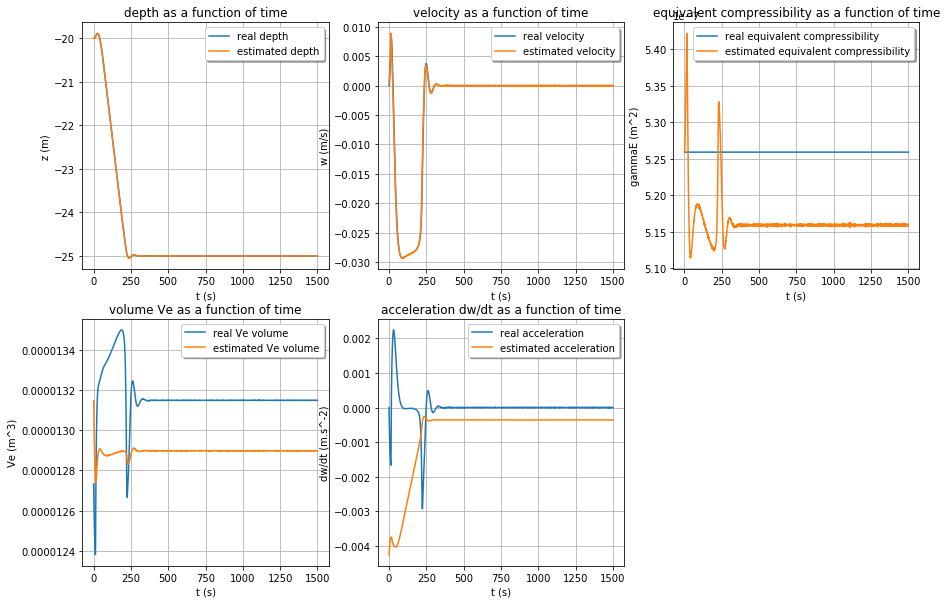

In [17]:
# time step float with control
#control = {'tau': 10.,'dz_nochattering': 1., 'mode': 'sliding', 'd3y_ctrl': afmax/f.m/1.}
#control = {'tau': 2.0, 'dz_nochattering': 1., 'mode': 'feedback', 'nu': 0.03*2./np.pi, 'delta': 0.02}
#control = {'tau': 2.0, 'dz_nochattering': 1., 'mode': 'kalman_feedback', 'nu': 0.03*2./np.pi, 'delta': 1.}



Ve_rms = 1e-6

kalman.update({
          'gamma_alpha': np.diag([(dt*A_coeff*Ve_rms)**2, (depth_rms*10.)**2, gamma_alpha_gammaE**2, (1e-1*dt*Ve_rms)**2] )})
#
f.time_step(w,T=1500., dt_step=.1, dt_store=1., z=-20., w=0., v=vstart,
             usepiston=True, z_target=z_target, ctrl=control, kalman=kalman, verbose=0)
plot_kalman(f)

 ctrl: dt_ctrl = 0.1
 ctrl: dz_nochattering = 0.0
 ctrl: tau = 8.78216204738521
 ctrl: nu = 0.01909859317102744
 ctrl: delta = 0.08782162047385213
 ctrl: kalman = <float_lib.Kalman object at 0x7fe8aaddc6a0>
 ctrl: mode = kalman_feedback
Start time stepping for 25 min ...
... time stepping done


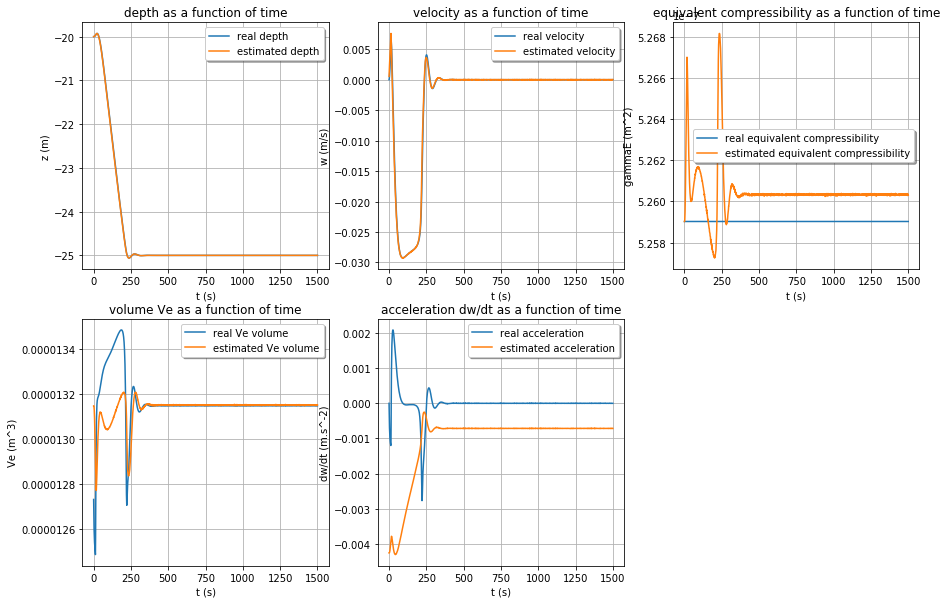

In [18]:
# time step float with control
#control = {'tau': 10.,'dz_nochattering': 1., 'mode': 'sliding', 'd3y_ctrl': afmax/f.m/1.}
#control = {'tau': 2.0, 'dz_nochattering': 1., 'mode': 'feedback', 'nu': 0.03*2./np.pi, 'delta': 0.02}
#control = {'tau': 2.0, 'dz_nochattering': 1., 'mode': 'kalman_feedback', 'nu': 0.03*2./np.pi, 'delta': 1.}



Ve_rms = 1e-5

kalman.update({
          'gamma_alpha': np.diag([(dt*A_coeff*Ve_rms)**2, (depth_rms*10.)**2, gamma_alpha_gammaE**2, (1e-1*dt*Ve_rms)**2] )})
#
f.time_step(w,T=1500., dt_step=.1, dt_store=1., z=-20., w=0., v=vstart,
             usepiston=True, z_target=z_target, ctrl=control, kalman=kalman, verbose=0)
plot_kalman(f)

 ctrl: dt_ctrl = 0.1
 ctrl: dz_nochattering = 0.0
 ctrl: tau = 8.78216204738521
 ctrl: nu = 0.01909859317102744
 ctrl: delta = 0.08782162047385213
 ctrl: kalman = <float_lib.Kalman object at 0x7fe8aa968400>
 ctrl: mode = kalman_feedback
Start time stepping for 25 min ...
... time stepping done


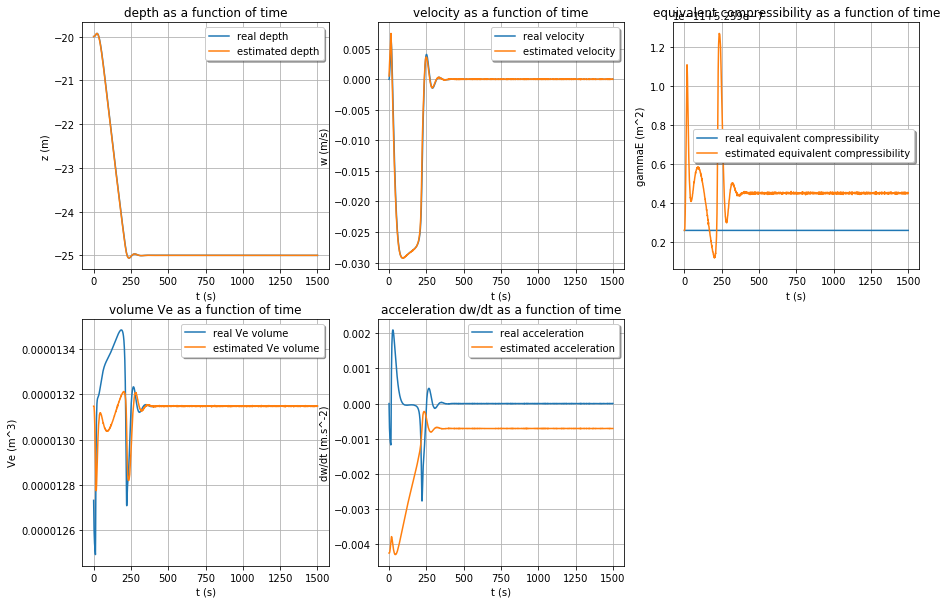

In [19]:
# time step float with control
#control = {'tau': 10.,'dz_nochattering': 1., 'mode': 'sliding', 'd3y_ctrl': afmax/f.m/1.}
#control = {'tau': 2.0, 'dz_nochattering': 1., 'mode': 'feedback', 'nu': 0.03*2./np.pi, 'delta': 0.02}
#control = {'tau': 2.0, 'dz_nochattering': 1., 'mode': 'kalman_feedback', 'nu': 0.03*2./np.pi, 'delta': 1.}



Ve_rms = 1e-4

kalman.update({
          'gamma_alpha': np.diag([(dt*A_coeff*Ve_rms)**2, (depth_rms*10.)**2, gamma_alpha_gammaE**2, (1e-1*dt*Ve_rms)**2] )})
#
f.time_step(w,T=1500., dt_step=.1, dt_store=1., z=-20., w=0., v=vstart,
             usepiston=True, z_target=z_target, ctrl=control, kalman=kalman, verbose=0)
plot_kalman(f)

 ctrl: dt_ctrl = 0.1
 ctrl: dz_nochattering = 0.0
 ctrl: tau = 8.78216204738521
 ctrl: nu = 0.01909859317102744
 ctrl: delta = 0.08782162047385213
 ctrl: kalman = <float_lib.Kalman object at 0x7fe8aa78bf60>
 ctrl: mode = kalman_feedback
Start time stepping for 25 min ...
... time stepping done


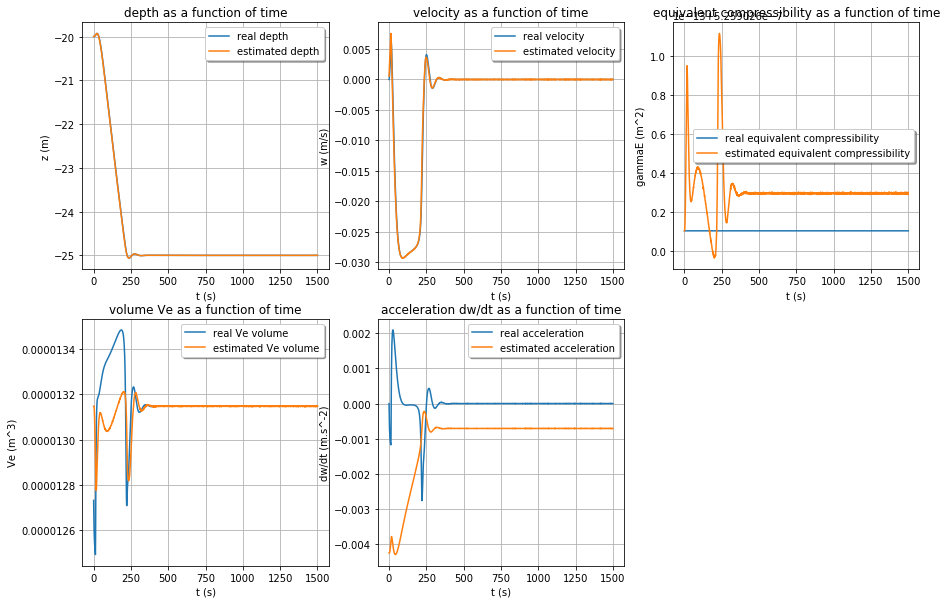

In [20]:
# time step float with control
#control = {'tau': 10.,'dz_nochattering': 1., 'mode': 'sliding', 'd3y_ctrl': afmax/f.m/1.}
#control = {'tau': 2.0, 'dz_nochattering': 1., 'mode': 'feedback', 'nu': 0.03*2./np.pi, 'delta': 0.02}
#control = {'tau': 2.0, 'dz_nochattering': 1., 'mode': 'kalman_feedback', 'nu': 0.03*2./np.pi, 'delta': 1.}



Ve_rms = 1e-3

kalman.update({
          'gamma_alpha': np.diag([(dt*A_coeff*Ve_rms)**2, (depth_rms*10.)**2, gamma_alpha_gammaE**2, (1e-1*dt*Ve_rms)**2] )})
#
f.time_step(w,T=1500., dt_step=.1, dt_store=1., z=-20., w=0., v=vstart,
             usepiston=True, z_target=z_target, ctrl=control, kalman=kalman, verbose=0)
plot_kalman(f)

---

### Kalman filter parameters : depth_rms variable

 ctrl: dt_ctrl = 0.1
 ctrl: dz_nochattering = 0.0
 ctrl: tau = 8.78216204738521
 ctrl: nu = 0.01909859317102744
 ctrl: delta = 0.08782162047385213
 ctrl: kalman = <float_lib.Kalman object at 0x7fe8aa81ac88>
 ctrl: mode = kalman_feedback
Start time stepping for 25 min ...
... time stepping done


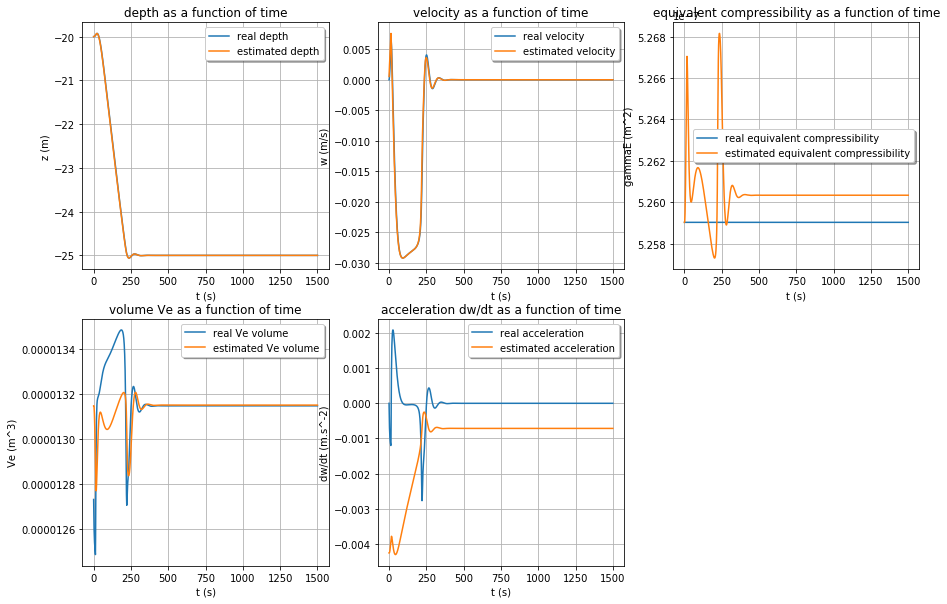

In [21]:
depth_rms = 1e-7 # m
vel_rms = depth_rms/dt # mm/s
Ve_rms = 1e-5
kalman.update({
          'gamma': np.diag([vel_rms**2, depth_rms**2, gamma_alpha_gammaE**2, (10.*t2V)**2]),
          'gamma_alpha': np.diag([(dt*A_coeff*Ve_rms)**2, (depth_rms*10.)**2, gamma_alpha_gammaE**2, (1e-1*dt*Ve_rms)**2] ),
          'gamma_beta': np.diag([depth_rms**2])})
#
f.time_step(w,T=1500., dt_step=.1, dt_store=1., z=-20., w=0., v=vstart,
             usepiston=True, z_target=z_target, ctrl=control, kalman=kalman, verbose=0)
plot_kalman(f)

 ctrl: dt_ctrl = 0.1
 ctrl: dz_nochattering = 0.0
 ctrl: tau = 8.78216204738521
 ctrl: nu = 0.01909859317102744
 ctrl: delta = 0.08782162047385213
 ctrl: kalman = <float_lib.Kalman object at 0x7fe8aa81a470>
 ctrl: mode = kalman_feedback
Start time stepping for 25 min ...
... time stepping done


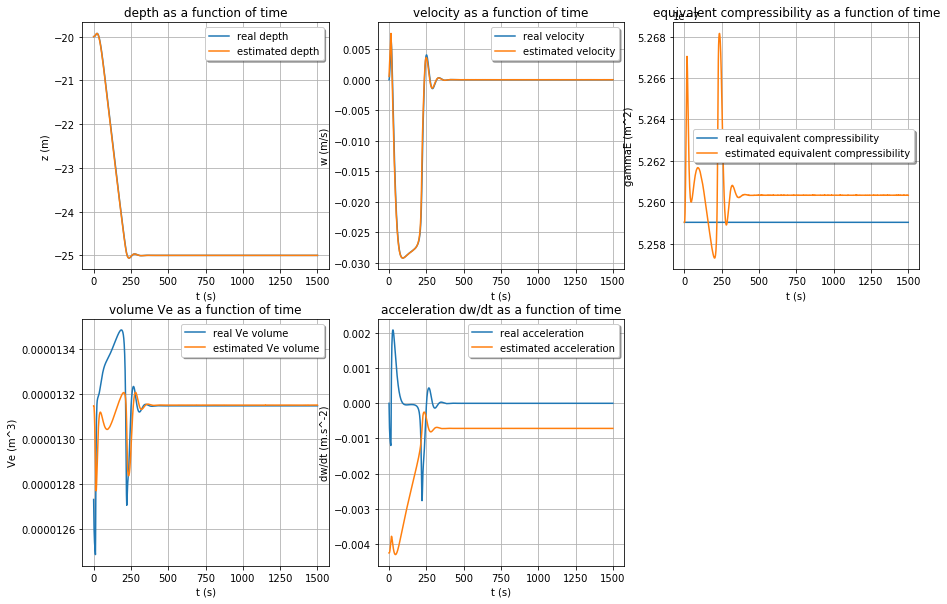

In [22]:
depth_rms = 1e-6 # m
vel_rms = depth_rms/dt # mm/s
kalman.update({
          'gamma': np.diag([vel_rms**2, depth_rms**2, gamma_alpha_gammaE**2, (10.*t2V)**2]),
          'gamma_alpha': np.diag([(dt*A_coeff*Ve_rms)**2, (depth_rms*10.)**2, gamma_alpha_gammaE**2, (1e-1*dt*Ve_rms)**2] ),
          'gamma_beta': np.diag([depth_rms**2])})
#
f.time_step(w,T=1500., dt_step=.1, dt_store=1., z=-20., w=0., v=vstart,
             usepiston=True, z_target=z_target, ctrl=control, kalman=kalman, verbose=0)
plot_kalman(f)

 ctrl: dt_ctrl = 0.1
 ctrl: dz_nochattering = 0.0
 ctrl: tau = 8.78216204738521
 ctrl: nu = 0.01909859317102744
 ctrl: delta = 0.08782162047385213
 ctrl: kalman = <float_lib.Kalman object at 0x7fe8aabc2c88>
 ctrl: mode = kalman_feedback
Start time stepping for 25 min ...
... time stepping done


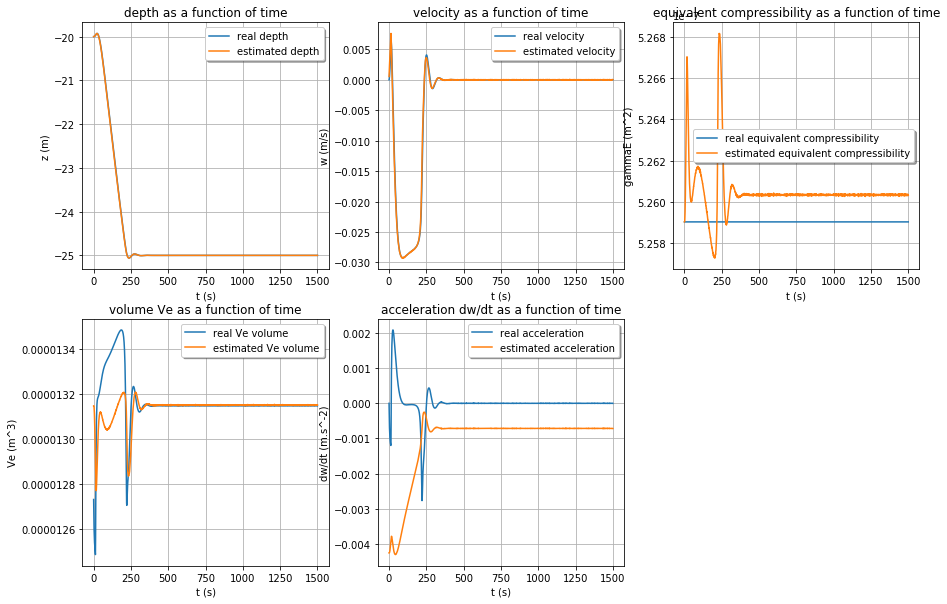

In [23]:
depth_rms = 1e-5 # m
vel_rms = depth_rms/dt # mm/s
kalman.update({
          'gamma': np.diag([vel_rms**2, depth_rms**2, gamma_alpha_gammaE**2, (10.*t2V)**2]),
          'gamma_alpha': np.diag([(dt*A_coeff*Ve_rms)**2, (depth_rms*10.)**2, gamma_alpha_gammaE**2, (1e-1*dt*Ve_rms)**2] ),
          'gamma_beta': np.diag([depth_rms**2])})
#
f.time_step(w,T=1500., dt_step=.1, dt_store=1., z=-20., w=0., v=vstart,
             usepiston=True, z_target=z_target, ctrl=control, kalman=kalman, verbose=0)
plot_kalman(f)

 ctrl: dt_ctrl = 0.1
 ctrl: dz_nochattering = 0.0
 ctrl: tau = 8.78216204738521
 ctrl: nu = 0.01909859317102744
 ctrl: delta = 0.08782162047385213
 ctrl: kalman = <float_lib.Kalman object at 0x7fe8aa972c50>
 ctrl: mode = kalman_feedback
Start time stepping for 25 min ...
... time stepping done


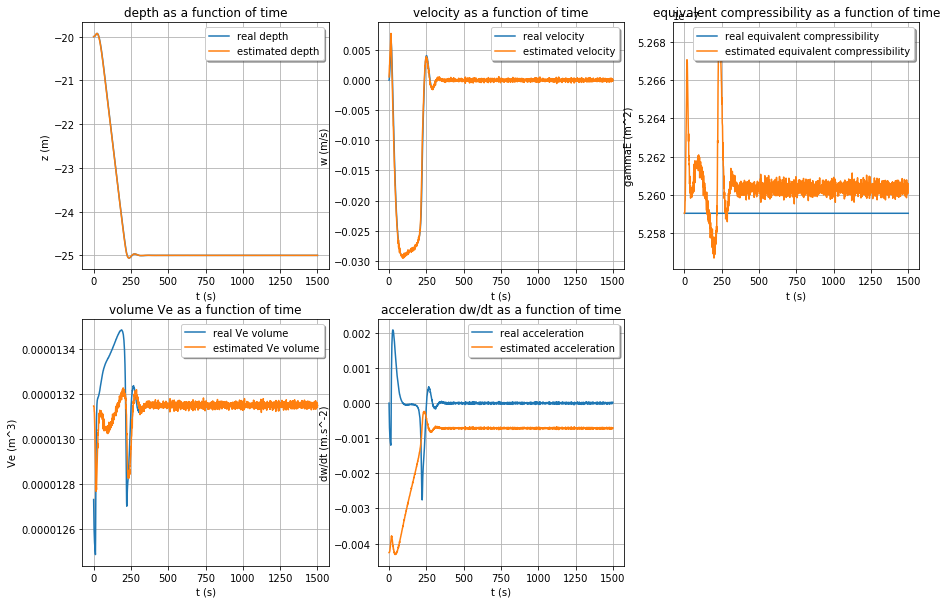

In [24]:
depth_rms = 1e-4 # m
vel_rms = depth_rms/dt # mm/s
kalman.update({
          'gamma': np.diag([vel_rms**2, depth_rms**2, gamma_alpha_gammaE**2, (10.*t2V)**2]),
          'gamma_alpha': np.diag([(dt*A_coeff*Ve_rms)**2, (depth_rms*10.)**2, gamma_alpha_gammaE**2, (1e-1*dt*Ve_rms)**2] ),
          'gamma_beta': np.diag([depth_rms**2])})
#
f.time_step(w,T=1500., dt_step=.1, dt_store=1., z=-20., w=0., v=vstart,
             usepiston=True, z_target=z_target, ctrl=control, kalman=kalman, verbose=0)
plot_kalman(f)

 ctrl: dt_ctrl = 0.1
 ctrl: dz_nochattering = 0.0
 ctrl: tau = 8.78216204738521
 ctrl: nu = 0.01909859317102744
 ctrl: delta = 0.08782162047385213
 ctrl: kalman = <float_lib.Kalman object at 0x7fe8aaf50898>
 ctrl: mode = kalman_feedback
Start time stepping for 25 min ...
... time stepping done


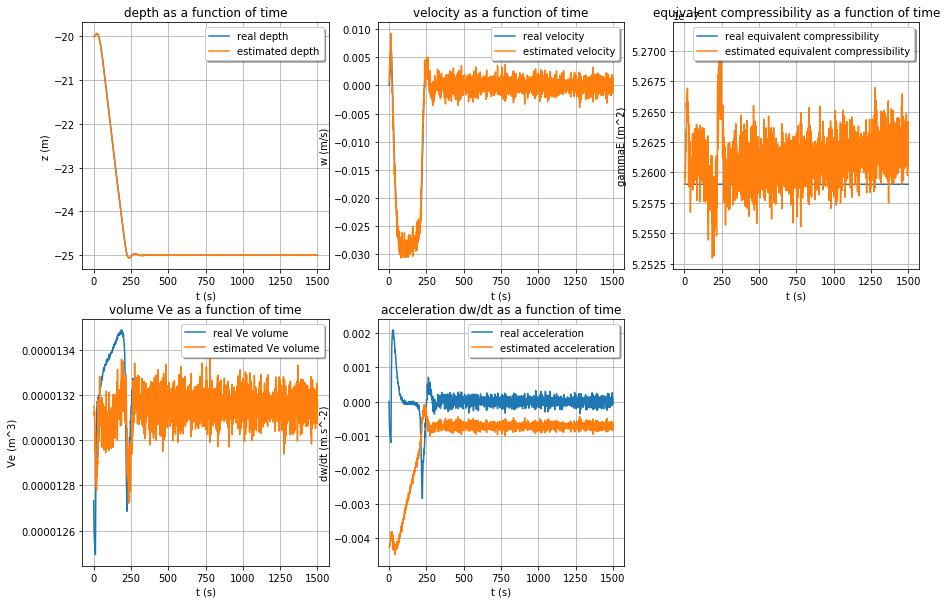

In [25]:
depth_rms = 1e-3 # m
vel_rms = depth_rms/dt # mm/s
kalman.update({
          'gamma': np.diag([vel_rms**2, depth_rms**2, gamma_alpha_gammaE**2, (10.*t2V)**2]),
          'gamma_alpha': np.diag([(dt*A_coeff*Ve_rms)**2, (depth_rms*10.)**2, gamma_alpha_gammaE**2, (1e-1*dt*Ve_rms)**2] ),
          'gamma_beta': np.diag([depth_rms**2])})
#
f.time_step(w,T=1500., dt_step=.1, dt_store=1., z=-20., w=0., v=vstart,
             usepiston=True, z_target=z_target, ctrl=control, kalman=kalman, verbose=0)
plot_kalman(f)

---

### Kalman filter parameters : gamma_alpha_gammaE variable

 ctrl: dt_ctrl = 0.1
 ctrl: dz_nochattering = 0.0
 ctrl: tau = 8.78216204738521
 ctrl: nu = 0.01909859317102744
 ctrl: delta = 0.08782162047385213
 ctrl: kalman = <float_lib.Kalman object at 0x7fe8aa8e3780>
 ctrl: mode = kalman_feedback
Start time stepping for 25 min ...
... time stepping done


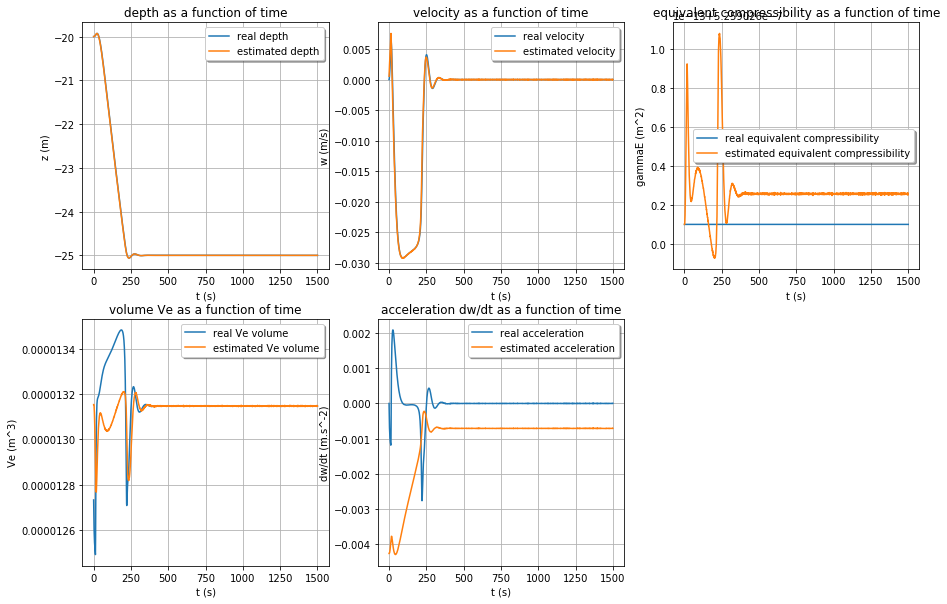

In [26]:
depth_rms = 1e-5 # m
vel_rms = depth_rms/dt # mm/s
gamma_alpha_gammaE = 1e-10
kalman.update({
          'gamma': np.diag([vel_rms**2, depth_rms**2, gamma_alpha_gammaE**2, (10.*t2V)**2]),
          'gamma_alpha': np.diag([(dt*A_coeff*Ve_rms)**2, (depth_rms*10.)**2, gamma_alpha_gammaE**2, (1e-1*dt*Ve_rms)**2] ),
          'gamma_beta': np.diag([depth_rms**2])})
#
f.time_step(w,T=1500., dt_step=.1, dt_store=1., z=-20., w=0., v=vstart,
             usepiston=True, z_target=z_target, ctrl=control, kalman=kalman, verbose=0)
plot_kalman(f)

 ctrl: dt_ctrl = 0.1
 ctrl: dz_nochattering = 0.0
 ctrl: tau = 8.78216204738521
 ctrl: nu = 0.01909859317102744
 ctrl: delta = 0.08782162047385213
 ctrl: kalman = <float_lib.Kalman object at 0x7fe8aaccb4a8>
 ctrl: mode = kalman_feedback
Start time stepping for 25 min ...
... time stepping done


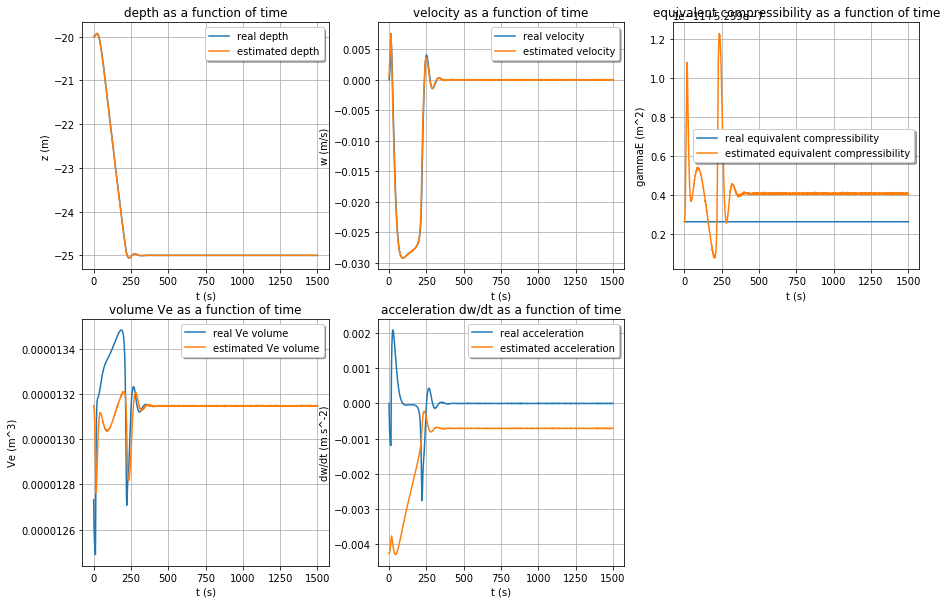

In [27]:
gamma_alpha_gammaE = 1e-9
kalman.update({
          'gamma': np.diag([vel_rms**2, depth_rms**2, gamma_alpha_gammaE**2, (10.*t2V)**2]),
          'gamma_alpha': np.diag([(dt*A_coeff*Ve_rms)**2, (depth_rms*10.)**2, gamma_alpha_gammaE**2, (1e-1*dt*Ve_rms)**2] )})
#
f.time_step(w,T=1500., dt_step=.1, dt_store=1., z=-20., w=0., v=vstart,
             usepiston=True, z_target=z_target, ctrl=control, kalman=kalman, verbose=0)
plot_kalman(f)

 ctrl: dt_ctrl = 0.1
 ctrl: dz_nochattering = 0.0
 ctrl: tau = 8.78216204738521
 ctrl: nu = 0.01909859317102744
 ctrl: delta = 0.08782162047385213
 ctrl: kalman = <float_lib.Kalman object at 0x7fe8aacd71d0>
 ctrl: mode = kalman_feedback
Start time stepping for 25 min ...
... time stepping done


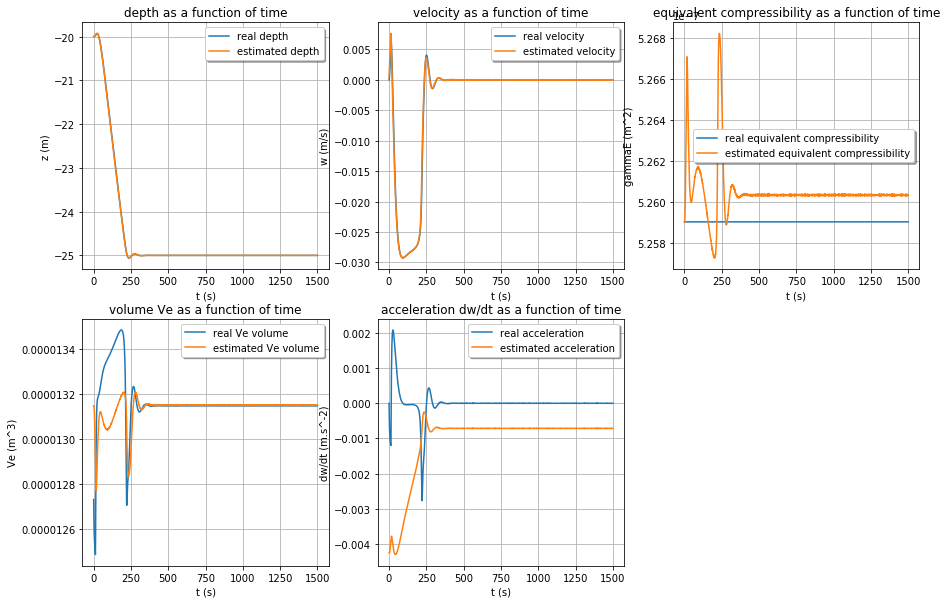

In [28]:
gamma_alpha_gammaE = 1e-8
kalman.update({
          'gamma': np.diag([vel_rms**2, depth_rms**2, gamma_alpha_gammaE**2, (10.*t2V)**2]),
          'gamma_alpha': np.diag([(dt*A_coeff*Ve_rms)**2, (depth_rms*10.)**2, gamma_alpha_gammaE**2, (1e-1*dt*Ve_rms)**2] )})
#
f.time_step(w,T=1500., dt_step=.1, dt_store=1., z=-20., w=0., v=vstart,
             usepiston=True, z_target=z_target, ctrl=control, kalman=kalman, verbose=0)
plot_kalman(f)

 ctrl: dt_ctrl = 0.1
 ctrl: dz_nochattering = 0.0
 ctrl: tau = 8.78216204738521
 ctrl: nu = 0.01909859317102744
 ctrl: delta = 0.08782162047385213
 ctrl: kalman = <float_lib.Kalman object at 0x7fe8ab006ef0>
 ctrl: mode = kalman_feedback
Start time stepping for 25 min ...
... time stepping done


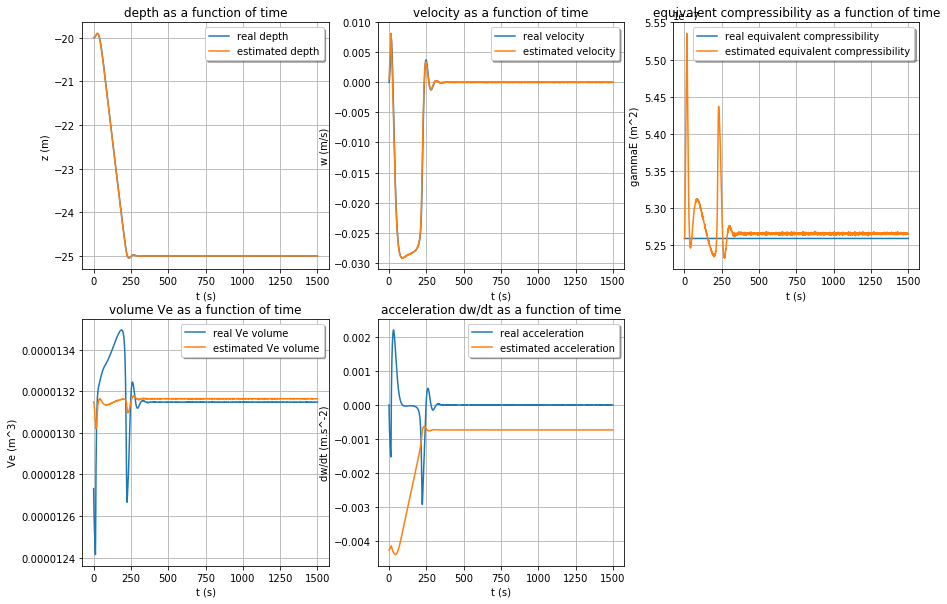

In [29]:
gamma_alpha_gammaE = 1e-7
kalman.update({
          'gamma': np.diag([vel_rms**2, depth_rms**2, gamma_alpha_gammaE**2, (10.*t2V)**2]),
          'gamma_alpha': np.diag([(dt*A_coeff*Ve_rms)**2, (depth_rms*10.)**2, gamma_alpha_gammaE**2, (1e-1*dt*Ve_rms)**2] )})
#
f.time_step(w,T=1500., dt_step=.1, dt_store=1., z=-20., w=0., v=vstart,
             usepiston=True, z_target=z_target, ctrl=control, kalman=kalman, verbose=0)
plot_kalman(f)

 ctrl: dt_ctrl = 0.1
 ctrl: dz_nochattering = 0.0
 ctrl: tau = 8.78216204738521
 ctrl: nu = 0.01909859317102744
 ctrl: delta = 0.08782162047385213
 ctrl: kalman = <float_lib.Kalman object at 0x7fe8aac599e8>
 ctrl: mode = kalman_feedback
Start time stepping for 25 min ...
... time stepping done


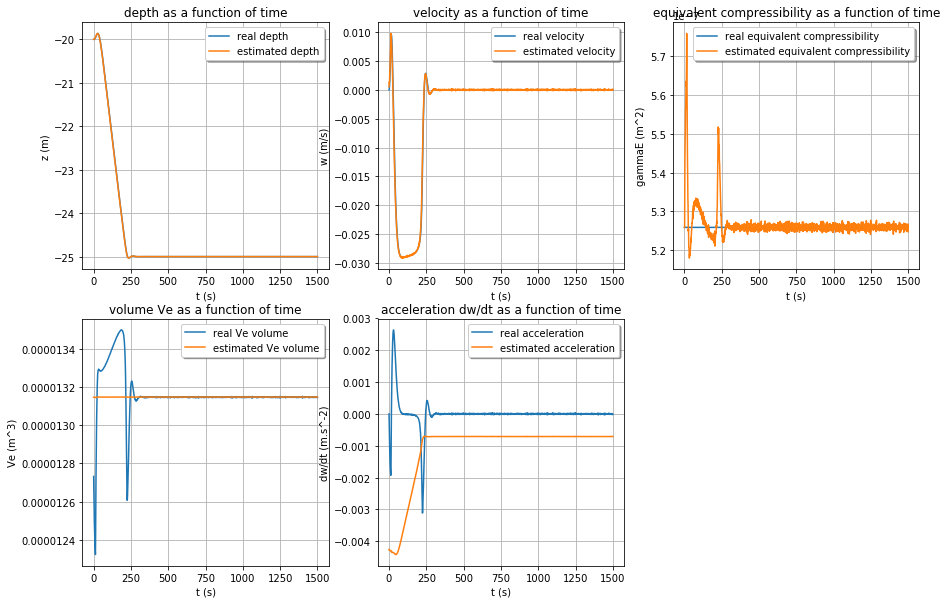

In [30]:
gamma_alpha_gammaE = 1e-6
kalman.update({
          'gamma': np.diag([vel_rms**2, depth_rms**2, gamma_alpha_gammaE**2, (10.*t2V)**2]),
          'gamma_alpha': np.diag([(dt*A_coeff*Ve_rms)**2, (depth_rms*10.)**2, gamma_alpha_gammaE**2, (1e-1*dt*Ve_rms)**2] )})
#
f.time_step(w,T=1500., dt_step=.1, dt_store=1., z=-20., w=0., v=vstart,
             usepiston=True, z_target=z_target, ctrl=control, kalman=kalman, verbose=0)
plot_kalman(f)

 ctrl: dt_ctrl = 0.1
 ctrl: dz_nochattering = 0.0
 ctrl: tau = 8.78216204738521
 ctrl: nu = 0.01909859317102744
 ctrl: delta = 0.08782162047385213
 ctrl: kalman = <float_lib.Kalman object at 0x7fe8aac0ee80>
 ctrl: mode = kalman_feedback
Start time stepping for 25 min ...
... time stepping done


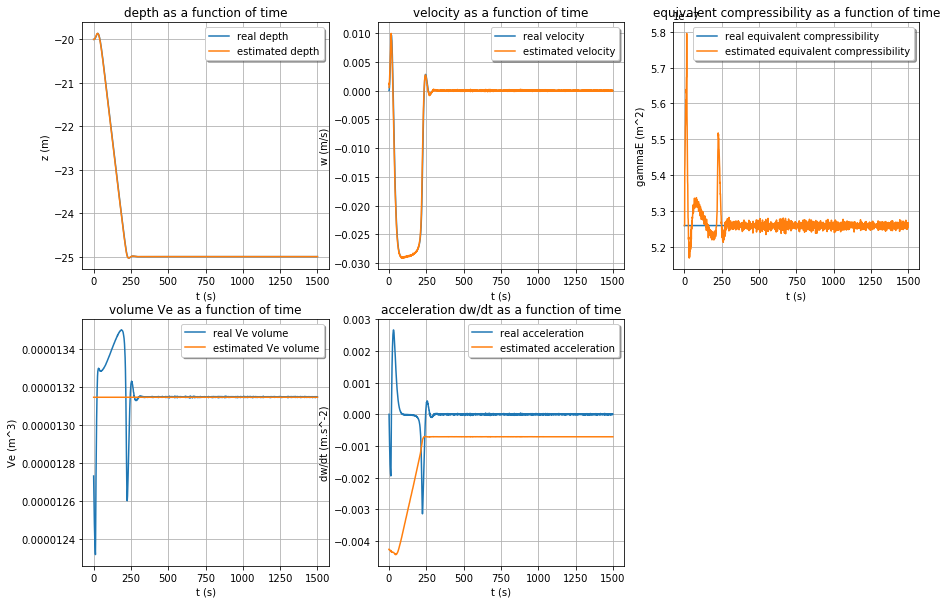

In [31]:
gamma_alpha_gammaE = 1e-5
kalman.update({
          'gamma': np.diag([vel_rms**2, depth_rms**2, gamma_alpha_gammaE**2, (10.*t2V)**2]),
          'gamma_alpha': np.diag([(dt*A_coeff*Ve_rms)**2, (depth_rms*10.)**2, gamma_alpha_gammaE**2, (1e-1*dt*Ve_rms)**2] )})
#
f.time_step(w,T=1500., dt_step=.1, dt_store=1., z=-20., w=0., v=vstart,
             usepiston=True, z_target=z_target, ctrl=control, kalman=kalman, verbose=0)
plot_kalman(f)

 ctrl: dt_ctrl = 0.1
 ctrl: dz_nochattering = 0.0
 ctrl: tau = 8.78216204738521
 ctrl: nu = 0.01909859317102744
 ctrl: delta = 0.08782162047385213
 ctrl: kalman = <float_lib.Kalman object at 0x7fe8aadf2940>
 ctrl: mode = kalman_feedback
Start time stepping for 25 min ...
... time stepping done


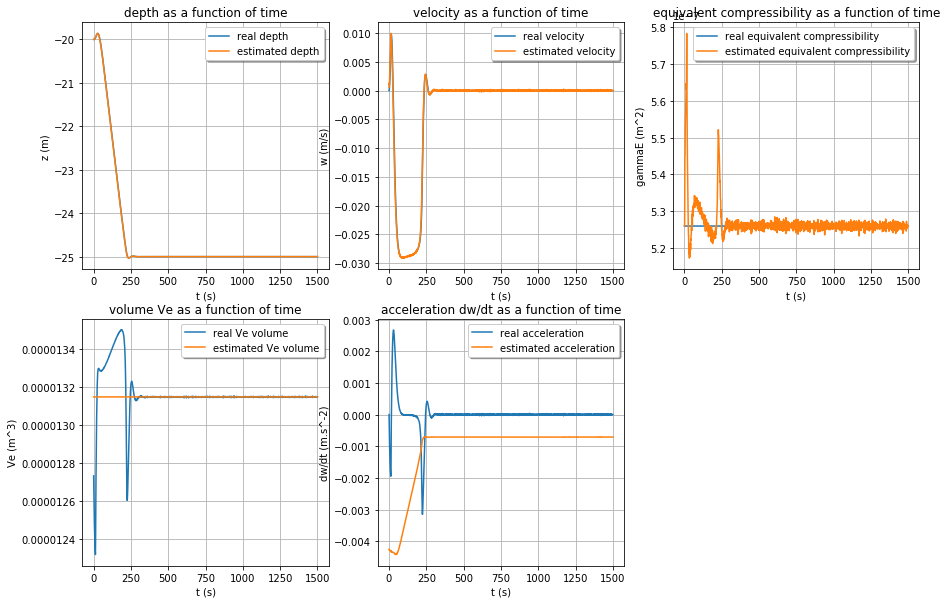

In [32]:
gamma_alpha_gammaE = 1e-4
kalman.update({
          'gamma': np.diag([vel_rms**2, depth_rms**2, gamma_alpha_gammaE**2, (10.*t2V)**2]),
          'gamma_alpha': np.diag([(dt*A_coeff*Ve_rms)**2, (depth_rms*10.)**2, gamma_alpha_gammaE**2, (1e-1*dt*Ve_rms)**2] )})
#
f.time_step(w,T=1500., dt_step=.1, dt_store=1., z=-20., w=0., v=vstart,
             usepiston=True, z_target=z_target, ctrl=control, kalman=kalman, verbose=0)
plot_kalman(f)

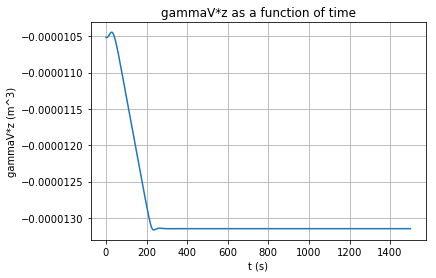

In [33]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(f.log.t, f.log.gammaV*f.log.z)
ax.set_title("gammaV*z as a function of time")
ax.set_xlabel("t (s)")
ax.set_ylabel("gammaV*z (m^3)")
ax.grid()

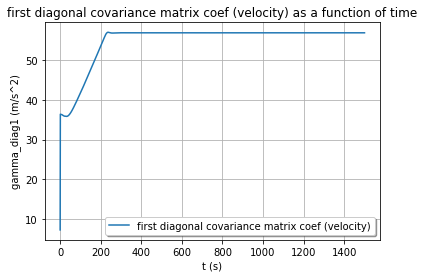

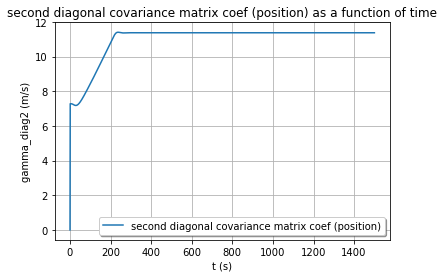

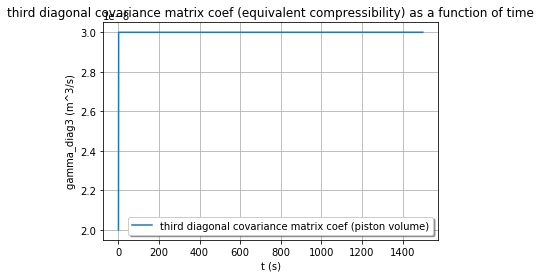

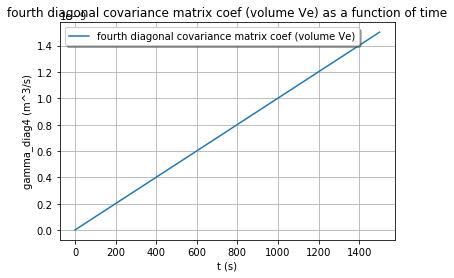

In [34]:
fig = plt.figure()
ax=fig.add_subplot(111)
ax.plot(f.t_kalman[1:],f.log.gamma_diag1, label ="first diagonal covariance matrix coef (velocity)")
ax.set_title("first diagonal covariance matrix coef (velocity) as a function of time")
ax.set_xlabel("t (s)")
ax.set_ylabel("gamma_diag1 (m/s^2)")
ax.grid()
legend = ax.legend(loc='best', shadow=True, fontsize='medium')

fig = plt.figure()
ax=fig.add_subplot(111)
ax.plot(f.t_kalman[1:],f.log.gamma_diag2, label ="second diagonal covariance matrix coef (position)")
ax.set_title("second diagonal covariance matrix coef (position) as a function of time")
ax.set_xlabel("t (s)")
ax.set_ylabel("gamma_diag2 (m/s)")
ax.grid()
legend = ax.legend(loc='best', shadow=True, fontsize='medium')

fig = plt.figure()
ax=fig.add_subplot(111)
ax.plot(f.t_kalman[1:],f.log.gamma_diag3, label ="third diagonal covariance matrix coef (piston volume)")
ax.set_title("third diagonal covariance matrix coef (equivalent compressibility) as a function of time")
ax.set_xlabel("t (s)")
ax.set_ylabel("gamma_diag3 (m^3/s)")
ax.grid()
legend = ax.legend(loc='best', shadow=True, fontsize='medium')

fig = plt.figure()
ax=fig.add_subplot(111)
ax.plot(f.t_kalman[1:],f.log.gamma_diag4, label ="fourth diagonal covariance matrix coef (volume Ve)")
ax.set_title("fourth diagonal covariance matrix coef (volume Ve) as a function of time")
ax.set_xlabel("t (s)")
ax.set_ylabel("gamma_diag4 (m^3/s)")
ax.grid()
legend = ax.legend(loc='best', shadow=True, fontsize='medium')

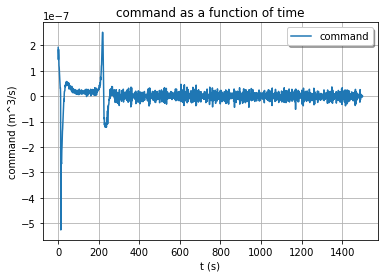

In [35]:
fig = plt.figure()
ax=fig.add_subplot(111)
ax.plot(f.log.t,f.log.u, label ="command")
ax.set_title("command as a function of time")
ax.set_xlabel("t (s)")
ax.set_ylabel("command (m^3/s)")
ax.grid()
legend = ax.legend(loc='best', shadow=True, fontsize='medium')

Extrapolated energy conssumption: 0.0 Wh/day = 0.0 Wh/30day


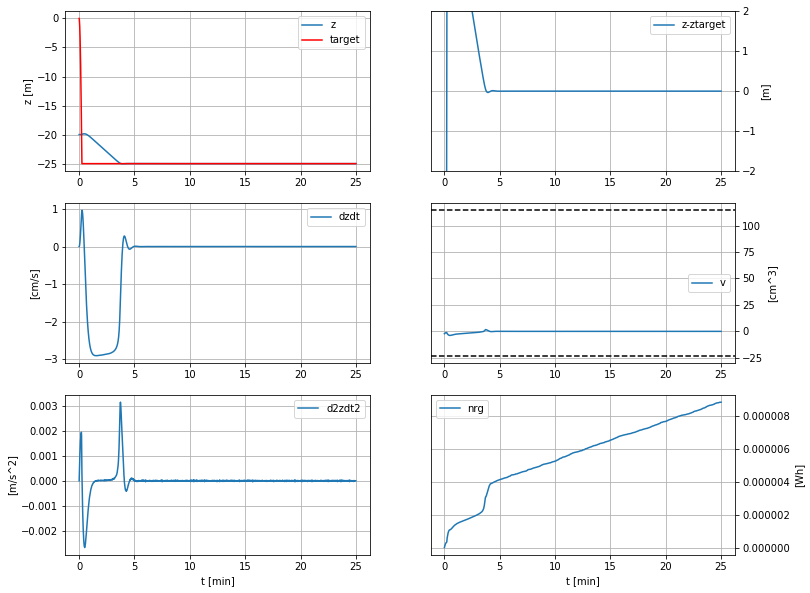

In [36]:
# plot log
plot_log(f,z_target=z_target)

---

## Oscillations around a fixed level

In [37]:
z_target = lambda t: -25+10.*np.sin(2.*np.pi/600.*t)

In [38]:
f.time_step(w,T=1800., dt_step=.1, dt_store=1.,
            usepiston=True, z_target=z_target, ctrl=control)

 ctrl: dt_ctrl = 0.1
 ctrl: dz_nochattering = 0.0
 ctrl: tau = 8.78216204738521
 ctrl: nu = 0.01909859317102744
 ctrl: delta = 0.08782162047385213
 ctrl: kalman = <float_lib.Kalman object at 0x7fe8aadf2940>
 ctrl: mode = kalman_feedback
Start time stepping for 30 min ...
... time stepping done


Extrapolated energy conssumption: 0.0 Wh/day = 0.0 Wh/30day


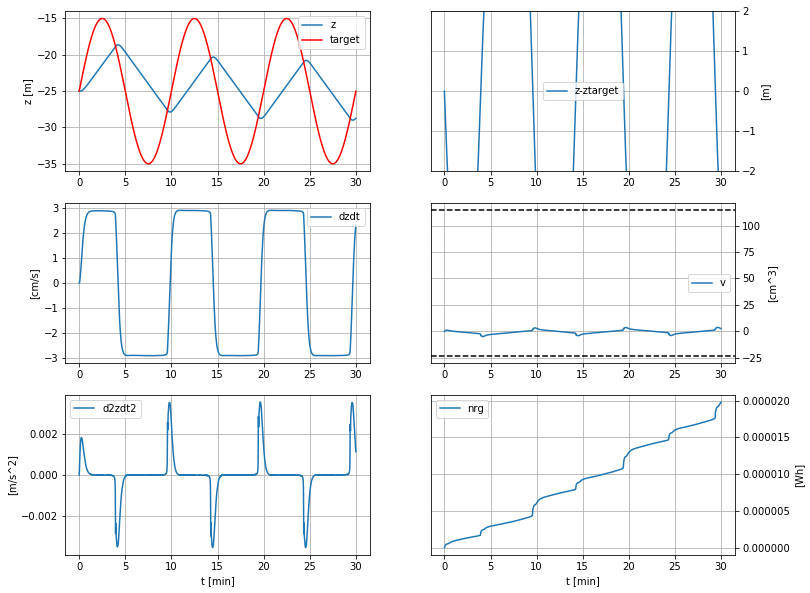

In [39]:
plot_log(f,z_target=z_target)

---

## Maintains depth level around moving isopycnals

In [40]:
eta = lambda t: 10.*np.sin(2.*np.pi/(60.*20.)*t)
z_target = lambda t: -25.+t*0.

In [41]:
f.time_step(w,T=1800., dt_step=.1, dt_store=1., usepiston=True, z_target=z_target, ctrl=control, eta=eta)

 ctrl: dt_ctrl = 0.1
 ctrl: dz_nochattering = 0.0
 ctrl: tau = 8.78216204738521
 ctrl: nu = 0.01909859317102744
 ctrl: delta = 0.08782162047385213
 ctrl: kalman = <float_lib.Kalman object at 0x7fe8aadf2940>
 ctrl: mode = kalman_feedback
Start time stepping for 30 min ...
... time stepping done


Extrapolated energy conssumption: 0.0 Wh/day = 0.0 Wh/30day


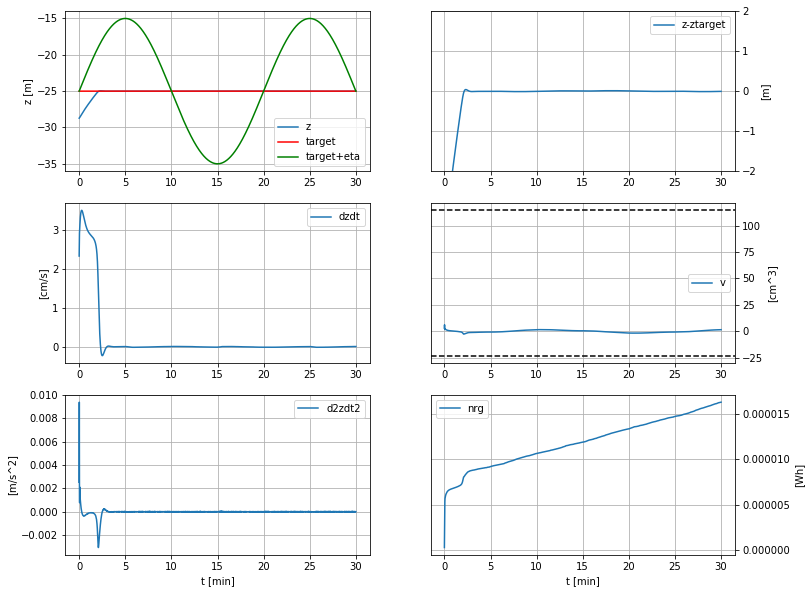

In [42]:
plot_log(f, z_target=z_target, eta=eta)

---

## Moving isopycnals without control

In [43]:
iz = np.argmin(np.abs(z+25.))
v = f.volume4equilibrium(p[iz],temp[iz],rho_w[iz])
f.time_step(w, T=1800., dt_step=.1, dt_store=1., z=-25., w=0., v=v, usepiston=False, eta=eta)

Start time stepping for 30 min ...
... time stepping done


Extrapolated energy conssumption: 0.0 Wh/day = 0.0 Wh/30day


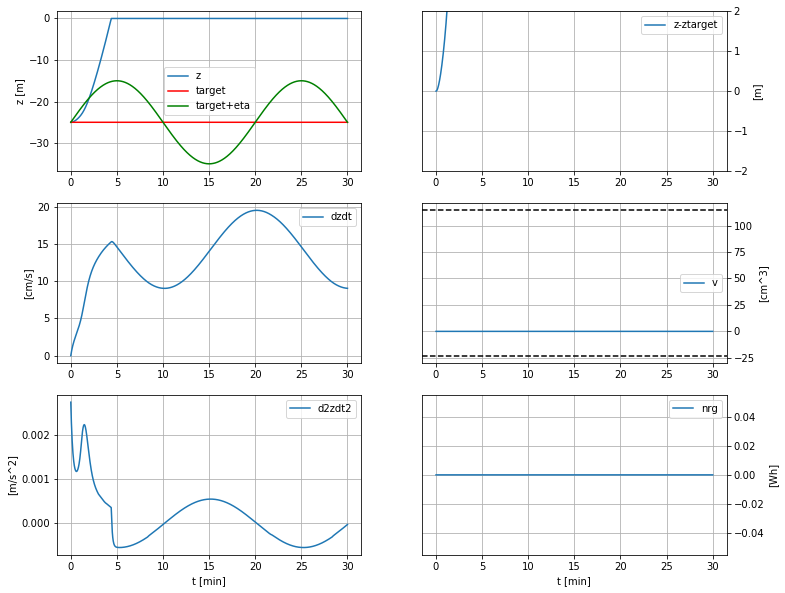

In [44]:
plot_log(f, z_target=z_target, eta=eta)